# Forecast Generation with TiREx

This notebook generates historical forecasts and latest forecasts for grocery products using TiREx.

In [1]:
# Import required libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Import torch first to check CUDA availability
import torch

# Set environment variables BEFORE importing anything else
os.environ['PYTORCH_DISABLE_DYNAMO'] = '1'

# Only configure for CPU if CUDA is not available
if not torch.cuda.is_available():
    os.environ['TIREX_NO_CUDA'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import duckdb
import uuid
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import TiREx
from tirex import load_model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using backend: {'CUDA' if torch.cuda.is_available() and os.environ.get('TIREX_NO_CUDA') != '1' else 'CPU (vanilla)'}")

PyTorch version: 2.7.1+cu126
CUDA available: False
Using backend: CPU (vanilla)


## 1. Create Forecast Table Schema

In [2]:
# Connect to database
conn = duckdb.connect('../data/grocery_final.db')

# Create forecast table
conn.execute("DROP TABLE IF EXISTS forecasts")

conn.execute("""
    CREATE TABLE forecasts (
        forecast_id TEXT PRIMARY KEY,
        run_id TEXT NOT NULL,
        forecast_date DATE NOT NULL,
        productId TEXT NOT NULL,
        target_date DATE NOT NULL,
        forecast_horizon INTEGER NOT NULL,
        predicted_quantity REAL NOT NULL,
        confidence_lower REAL NOT NULL,
        confidence_upper REAL NOT NULL,
        model_name TEXT DEFAULT 'TiREx',
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (productId) REFERENCES products(productId)
    )
""")

# Create indexes
conn.execute("CREATE INDEX idx_forecasts_product_date ON forecasts(productId, forecast_date)")
conn.execute("CREATE INDEX idx_forecasts_target_date ON forecasts(target_date)")
conn.execute("CREATE INDEX idx_forecasts_run_id ON forecasts(run_id)")

print("✓ Forecast table created successfully")

✓ Forecast table created successfully


## 2. Load TiREx Model

In [3]:
# Load TiREx model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model("NX-AI/TiRex", device=device)
print(f"✓ Model loaded on {device}")

✓ Model loaded on cpu


## 3. Helper Functions

In [4]:
def get_products_from_sales(conn, min_days=90):
    """Get all unique products from sales table"""
    query = """
        SELECT DISTINCT
            s.productId,
            p.name as product_name,
            p.category,
            COUNT(DISTINCT CAST(s.saleDate AS DATE)) as days_with_sales,
            SUM(s.quantity) as total_quantity
        FROM sales s
        JOIN products p ON s.productId = p.productId
        GROUP BY s.productId, p.name, p.category
        HAVING days_with_sales >= ?  -- Minimum days with sales
        ORDER BY total_quantity DESC
    """
    return conn.execute(query, [min_days]).df()

def get_top_products(conn, limit=100):
    """Get top products by sales volume (for test mode)"""
    query = """
        SELECT 
            s.productId,
            p.name as product_name,
            p.category,
            COUNT(DISTINCT CAST(s.saleDate AS DATE)) as days_with_sales,
            SUM(s.quantity) as total_quantity
        FROM sales s
        JOIN products p ON s.productId = p.productId
        GROUP BY s.productId, p.name, p.category
        HAVING days_with_sales >= 180  -- At least 6 months of data
        ORDER BY total_quantity DESC
        LIMIT ?
    """
    return conn.execute(query, [limit]).df()

def prepare_time_series_batch(conn, product_ids, end_date, context_length=90):
    """Prepare time series data for multiple products"""
    batch_context = []
    
    # Get date range for context
    start_date = end_date - timedelta(days=context_length)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    for pid in product_ids:
        # Get daily sales
        sales_data = conn.execute("""
            SELECT 
                CAST(saleDate AS DATE) as sale_date,
                SUM(quantity) as daily_quantity
            FROM sales
            WHERE productId = ? 
                AND CAST(saleDate AS DATE) >= ?
                AND CAST(saleDate AS DATE) <= ?
            GROUP BY CAST(saleDate AS DATE)
        """, [pid, start_date.date(), end_date.date()]).df()
        
        # Create time series
        ts_data = pd.Series(index=date_range, data=0.0)
        for _, row in sales_data.iterrows():
            sale_date = pd.to_datetime(row['sale_date'])
            if sale_date in ts_data.index:
                ts_data[sale_date] = row['daily_quantity']
        
        # Get context (last context_length days)
        context = ts_data.values[-context_length:]
        batch_context.append(context)
    
    return np.array(batch_context)

def generate_forecasts_batch(model, batch_context, prediction_length=14):
    """Generate forecasts for a batch of products"""
    # Convert to tensor
    context_tensor = torch.tensor(batch_context, dtype=torch.float32)
    
    # Generate forecasts
    quantiles, mean = model.forecast(
        context=context_tensor,
        prediction_length=prediction_length,
        batch_size=len(batch_context),
        output_type="numpy"
    )
    
    return mean, quantiles

def save_forecasts_batch(conn, forecast_records):
    """Save forecast records to database"""
    if not forecast_records:
        return
    
    # Insert records
    for record in forecast_records:
        conn.execute("""
            INSERT INTO forecasts (
                forecast_id, run_id, forecast_date, productId, target_date,
                forecast_horizon, predicted_quantity, confidence_lower, confidence_upper
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, [record['forecast_id'], record['run_id'], record['forecast_date'], 
              record['productId'], record['target_date'], record['forecast_horizon'],
              record['predicted_quantity'], record['confidence_lower'], record['confidence_upper']])

## 4. Test with Small Sample

In [5]:
# Test parameters
TEST_MODE = False  # Set to False for production mode
TEST_PRODUCTS = 3
TEST_DAYS = 7  # Test with 7 days of historical forecasts

# Get products based on mode
if TEST_MODE:
    # Test mode: use top products by sales
    products_df = get_top_products(conn, TEST_PRODUCTS)
    print(f"TEST MODE: Selected top {len(products_df)} products by sales volume")
else:
    # Production mode: use ALL unique products from sales
    products_df = get_products_from_sales(conn, min_days=90)
    print(f"PRODUCTION MODE: Selected {len(products_df)} unique products from sales")

print("\nSample products:")
print(products_df[['product_name', 'total_quantity']].head(10))

PRODUCTION MODE: Selected 2069 unique products from sales

Sample products:
                           product_name  total_quantity
0                                Banana        261423.0
1                           Corned Beef        162449.0
2                         Baking Potato        130704.0
3           Baked Beans in Tomato Sauce         87023.0
4                   Wheat Bisks 36 Pack         81233.0
5                  Garden Peas in Water         65486.0
6               British Baking Potatoes         54447.0
7                 Golden Vegetable Rice         52379.0
8  British Extra Lean Beef Mince 3% Fat         44881.0
9                          Rice Pudding         43622.0


In [8]:
# Get date range
date_info = conn.execute("""
    SELECT 
        MIN(CAST(saleDate AS DATE)) as min_date,
        MAX(CAST(saleDate AS DATE)) as max_date
    FROM sales
""").fetchone()

min_date = pd.to_datetime(date_info[0])
max_date = pd.to_datetime(date_info[1])

print(f"Sales data range: {min_date.date()} to {max_date.date()}")

# Generate forecast dates (daily forecasts)
if TEST_MODE:
    # Test mode: just last TEST_DAYS days
    historical_days = TEST_DAYS
else:
    # Production mode: last 156 days as requested
    historical_days = 7

# Calculate start date for historical forecasts
start_date = max_date - timedelta(days=historical_days - 1)

# Ensure we have enough context (90 days before first forecast)
earliest_possible = min_date + timedelta(days=90)
if start_date < earliest_possible:
    start_date = earliest_possible
    print(f"\\nAdjusted start date to {start_date.date()} to ensure 90-day context")

# Generate daily forecast dates
forecast_dates = []
current_date = start_date

while current_date <= max_date:
    forecast_dates.append(current_date)
    current_date += timedelta(days=1)

print(f"\nWill generate forecasts for {len(forecast_dates)} days")
print(f"Date range: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
print(f"Each forecast will predict 7 days ahead")

if TEST_MODE:
    print("\nForecast dates:")
    for date in forecast_dates:
        print(f"  - {date.date()}")

Sales data range: 2023-07-12 to 2025-07-09

Will generate forecasts for 7 days
Date range: 2025-07-03 to 2025-07-09
Each forecast will predict 7 days ahead


## 5. Generate Historical Forecasts

In [9]:
# Generate forecasts for each date
total_records = 0
batch_size = 3 if TEST_MODE else 20  # Larger batches for production
context_length = 90
prediction_length = 7  # 7-day forecast horizon as requested

print(f"\nGenerating {len(products_df)} products × {len(forecast_dates)} dates × {prediction_length} days = {len(products_df) * len(forecast_dates) * prediction_length:,} forecasts")

for forecast_date in tqdm(forecast_dates, desc="Generating forecasts"):
    run_id = str(uuid.uuid4())
    forecast_records = []
    
    # Process products in batches
    for i in range(0, len(products_df), batch_size):
        batch_products = products_df.iloc[i:i+batch_size]
        product_ids = batch_products['productId'].tolist()
        
        # Prepare context
        batch_context = prepare_time_series_batch(conn, product_ids, forecast_date, context_length)
        
        # Generate forecasts
        try:
            mean, quantiles = generate_forecasts_batch(model, batch_context, prediction_length)
            
            # Store forecast records
            for j, pid in enumerate(product_ids):
                for h in range(prediction_length):
                    forecast_records.append({
                        'forecast_id': str(uuid.uuid4()),
                        'run_id': run_id,
                        'forecast_date': forecast_date.date(),
                        'productId': pid,
                        'target_date': (forecast_date + timedelta(days=h+1)).date(),
                        'forecast_horizon': h + 1,
                        'predicted_quantity': float(mean[j, h]),
                        'confidence_lower': float(quantiles[j, h, 0]),
                        'confidence_upper': float(quantiles[j, h, -1])
                    })
        except Exception as e:
            print(f"\nError in batch: {e}")
            continue
    
    # Save to database
    save_forecasts_batch(conn, forecast_records)
    total_records += len(forecast_records)
    conn.commit()

print(f"\n✓ Generated {total_records:,} forecast records")


Generating 2069 products × 7 dates × 7 days = 101,381 forecasts


Generating forecasts:  71%|███████▏  | 5/7 [30:21<12:08, 364.38s/it]


FatalException: FATAL Error: Failed to create checkpoint because of error: Could not remove file "/home/abobreshov/work/dataart/talk2data/grocery_poc/src/notebooks/../data/grocery_final.db.wal": No such file or directory

## 6. Create Analytical Views

In [15]:
# Create latest forecasts view
conn.execute("DROP VIEW IF EXISTS latest_forecasts")
conn.execute("""
    CREATE VIEW latest_forecasts AS
    SELECT * FROM forecasts 
    WHERE (productId, forecast_date) IN (
        SELECT productId, MAX(forecast_date) 
        FROM forecasts 
        GROUP BY productId
    )
""")

# Create forecast accuracy view
conn.execute("DROP VIEW IF EXISTS forecast_accuracy")
conn.execute("""
    CREATE VIEW forecast_accuracy AS
    SELECT 
        f.productId,
        f.forecast_date,
        f.target_date,
        f.forecast_horizon,
        f.predicted_quantity,
        s.actual_quantity,
        ABS(f.predicted_quantity - s.actual_quantity) as absolute_error,
        CASE 
            WHEN s.actual_quantity > 0 
            THEN (f.predicted_quantity - s.actual_quantity) / s.actual_quantity 
            ELSE NULL 
        END as relative_error
    FROM forecasts f
    LEFT JOIN (
        SELECT productId, 
               CAST(saleDate AS DATE) as sale_date,
               SUM(quantity) as actual_quantity
        FROM sales
        GROUP BY productId, CAST(saleDate AS DATE)
    ) s ON f.productId = s.productId AND f.target_date = s.sale_date
    WHERE s.actual_quantity IS NOT NULL
""")

print("✓ Analytical views created")

✓ Analytical views created


## 7. Verify Results

In [16]:
# Summary statistics
stats = conn.execute("""
    SELECT 
        COUNT(DISTINCT forecast_date) as num_dates,
        COUNT(DISTINCT productId) as num_products,
        COUNT(*) as total_forecasts,
        MIN(forecast_date) as earliest_date,
        MAX(forecast_date) as latest_date
    FROM forecasts
""").fetchone()

print("Forecast Summary:")
print(f"  - Forecast dates: {stats[0]}")
print(f"  - Products: {stats[1]}")
print(f"  - Total records: {stats[2]:,}")
print(f"  - Date range: {stats[3]} to {stats[4]}")

# Sample forecasts
print("\nSample Forecasts:")
samples = conn.execute("""
    SELECT 
        p.name as product_name,
        f.forecast_date,
        f.target_date,
        f.predicted_quantity,
        f.confidence_lower,
        f.confidence_upper
    FROM forecasts f
    JOIN products p ON f.productId = p.productId
    WHERE f.forecast_horizon = 1
    ORDER BY f.forecast_date DESC, f.predicted_quantity DESC
    LIMIT 5
""").df()

print(samples)

Forecast Summary:
  - Forecast dates: 7
  - Products: 3
  - Total records: 147
  - Date range: 2025-07-03 to 2025-07-09

Sample Forecasts:
                           product_name forecast_date target_date  \
0             Chicken Tikka Filled Naan    2025-07-09  2025-07-10   
1      Ready To Eat Roast Whole Chicken    2025-07-09  2025-07-10   
2  100% British Beef Wagyu Fillet Steak    2025-07-09  2025-07-10   
3             Chicken Tikka Filled Naan    2025-07-08  2025-07-09   
4      Ready To Eat Roast Whole Chicken    2025-07-08  2025-07-09   

   predicted_quantity  confidence_lower  confidence_upper  
0          114.068596         90.061890        148.287750  
1           65.151657         49.709152         83.413269  
2           12.502313          8.715284         17.172276  
3          129.167145        103.003754        166.622604  
4           74.339638         60.975128         91.678177  


## 8. Generate Latest Forecast

In [ ]:
# Get latest date and generate fresh forecast
latest_date = pd.to_datetime(conn.execute("SELECT MAX(CAST(saleDate AS DATE)) FROM sales").fetchone()[0])
print(f"Generating 7-day forecast from {latest_date.date()}...")

# Use the same products as historical forecasts
active_products = products_df
print(f"Forecasting for {len(active_products)} products...")

# Generate latest forecasts
run_id = str(uuid.uuid4())
latest_forecast_records = []
batch_size = 3 if TEST_MODE else 20
prediction_length = 7  # 7-day forecast

for i in tqdm(range(0, len(active_products), batch_size), desc="Generating latest forecasts"):
    batch_products = active_products.iloc[i:i+batch_size]
    product_ids = batch_products['productId'].tolist()
    
    # Prepare context
    batch_context = prepare_time_series_batch(conn, product_ids, latest_date, context_length)
    
    # Generate forecasts
    try:
        mean, quantiles = generate_forecasts_batch(model, batch_context, prediction_length)
        
        # Store forecast records
        for j, pid in enumerate(product_ids):
            for h in range(prediction_length):
                latest_forecast_records.append({
                    'forecast_id': str(uuid.uuid4()),
                    'run_id': run_id,
                    'forecast_date': latest_date.date(),
                    'productId': pid,
                    'target_date': (latest_date + timedelta(days=h+1)).date(),
                    'forecast_horizon': h + 1,
                    'predicted_quantity': float(mean[j, h]),
                    'confidence_lower': float(quantiles[j, h, 0]),
                    'confidence_upper': float(quantiles[j, h, -1])
                })
    except Exception as e:
        print(f"\nError in batch: {e}")
        continue

# Save latest forecasts
save_forecasts_batch(conn, latest_forecast_records)
conn.commit()

print(f"\n✓ Generated {len(latest_forecast_records):,} latest forecast records")
print(f"✓ Forecast covers {latest_date.date()} to {(latest_date + timedelta(days=7)).date()}")

## 9. Visualize Forecast Accuracy

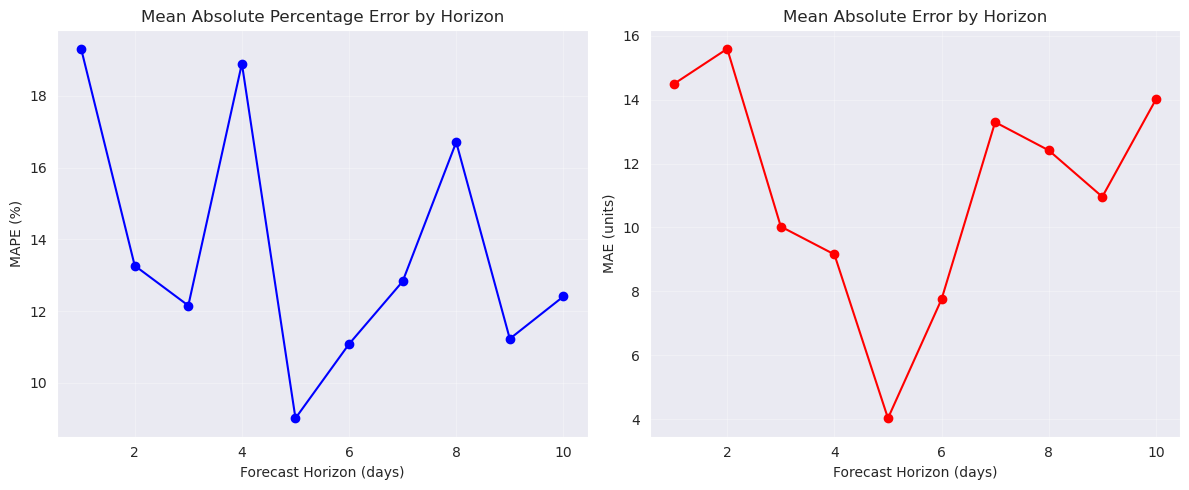


Accuracy Summary:
   forecast_horizon      mape        mae  num_forecasts
0                 1  0.193110  14.483780              6
1                 2  0.132650  15.587333              6
2                 3  0.121515  10.029146              6
3                 4  0.188982   9.157621              3
4                 5  0.090097   4.035004              3
5                 6  0.110792   7.755836              3
6                 7  0.128251  13.293947              3
7                 8  0.167079  12.412483              3
8                 9  0.112254  10.960140              3
9                10  0.124050  14.002374              3


In [12]:
# Get accuracy metrics
accuracy_df = conn.execute("""
    SELECT 
        forecast_horizon,
        AVG(ABS(relative_error)) as mape,
        AVG(absolute_error) as mae,
        COUNT(*) as num_forecasts
    FROM forecast_accuracy
    WHERE relative_error IS NOT NULL
        AND ABS(relative_error) < 2  -- Remove outliers
    GROUP BY forecast_horizon
    ORDER BY forecast_horizon
""").df()

if len(accuracy_df) > 0:
    # Plot accuracy by horizon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # MAPE by horizon
    ax1.plot(accuracy_df['forecast_horizon'], accuracy_df['mape'] * 100, 'b-o')
    ax1.set_xlabel('Forecast Horizon (days)')
    ax1.set_ylabel('MAPE (%)')
    ax1.set_title('Mean Absolute Percentage Error by Horizon')
    ax1.grid(True, alpha=0.3)
    
    # MAE by horizon
    ax2.plot(accuracy_df['forecast_horizon'], accuracy_df['mae'], 'r-o')
    ax2.set_xlabel('Forecast Horizon (days)')
    ax2.set_ylabel('MAE (units)')
    ax2.set_title('Mean Absolute Error by Horizon')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAccuracy Summary:")
    print(accuracy_df)
else:
    print("No accuracy data available yet (forecasts too recent)")

## 10. Query Latest Forecasts

In [13]:
# Show latest forecasts for top products
latest_forecasts = conn.execute("""
    SELECT 
        p.name as product_name,
        f.target_date,
        f.predicted_quantity,
        f.confidence_lower,
        f.confidence_upper,
        f.forecast_horizon
    FROM latest_forecasts f
    JOIN products p ON f.productId = p.productId
    WHERE f.forecast_date = (
        SELECT MAX(forecast_date) FROM forecasts
    )
    AND f.forecast_horizon <= 7  -- Next week only
    ORDER BY f.predicted_quantity DESC, f.target_date
    LIMIT 10
""").df()

print("Top Products - Next 7 Days Forecast:")
print(latest_forecasts)

# Close connection
conn.close()

Top Products - Next 7 Days Forecast:
                       product_name target_date  predicted_quantity  \
0         Chicken Tikka Filled Naan  2025-07-15          161.919952   
1         Chicken Tikka Filled Naan  2025-07-14          153.875153   
2         Chicken Tikka Filled Naan  2025-07-16          136.148407   
3         Chicken Tikka Filled Naan  2025-07-13          125.079765   
4         Chicken Tikka Filled Naan  2025-07-10          114.068596   
5         Chicken Tikka Filled Naan  2025-07-12           99.063774   
6         Chicken Tikka Filled Naan  2025-07-11           98.634079   
7  Ready To Eat Roast Whole Chicken  2025-07-14           81.155823   
8  Ready To Eat Roast Whole Chicken  2025-07-15           79.471977   
9  Ready To Eat Roast Whole Chicken  2025-07-16           77.085655   

   confidence_lower  confidence_upper  forecast_horizon  
0        128.685837        200.620514                 6  
1        121.229172        195.641357                 5  
2      

## Summary

This notebook has:
1. Created a forecast table in the database
2. Generated historical weekly forecasts
3. Created the latest 14-day forecast
4. Set up analytical views for accuracy tracking
5. Visualized forecast accuracy metrics

To run in production mode:
- Set `TEST_MODE = False`
- Adjust `TEST_PRODUCTS` and other parameters as needed